In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models

from sklearn.metrics import mean_squared_error

from assets.graph_functions import plot_signal_data

import h5py
import warnings

warnings.filterwarnings('ignore')

time_window = 2 * 1.2
fs = 360
n = 864

np.random.seed(42)
tf.random.set_seed(42)

tt = np.linspace(0, time_window, n)

In [2]:
xtrain = h5py.File('data/X_train.h5', 'r')
ytrain = h5py.File('data/y_train.h5', 'r')
xtest = h5py.File('data/X_test.h5', 'r')
ytest = h5py.File('data/y_test.h5', 'r')

xtrain_d = xtrain.get('X_train')
ytrain_d = ytrain.get('y_train')
xtest_d = xtest.get('X_test')
ytest_d = ytest.get('y_test')

In [3]:
X_train = xtrain_d[:]
y_train = ytrain_d[:]
X_test = xtest_d[:]
y_test = ytest_d[:]

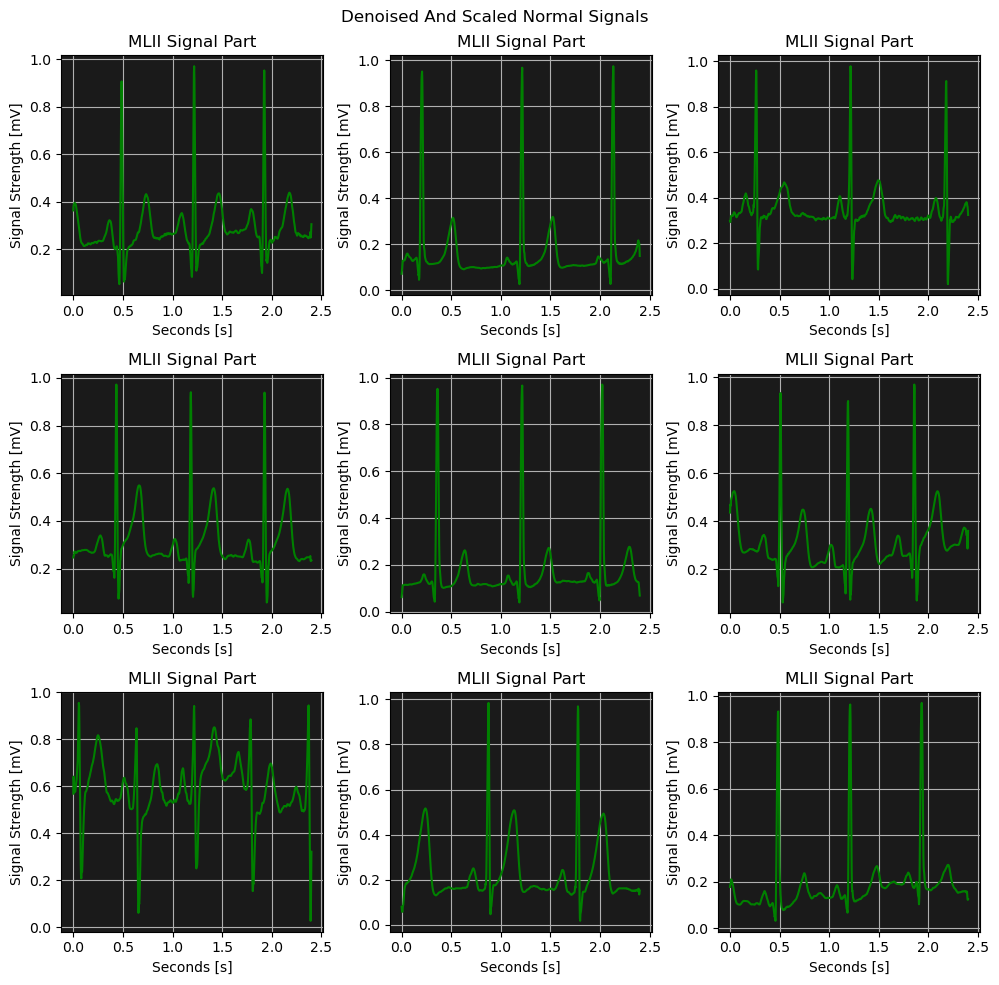

In [43]:
fig, axes = plt.subplots(figsize=(10,10), nrows=3, ncols=3)

for ax, idx in zip(axes.flatten(), range(9)):
    plot_signal_data(ax, tt, X_train[idx])

fig.suptitle("Denoised And Scaled Normal Signals")
plt.tight_layout()
plt.show()

In [7]:
anomaly_ids = np.where(y_test == 1)
normal_ids = np.where(y_test == 0)

temp = X_test[anomaly_ids]
normal = X_test[normal_ids]

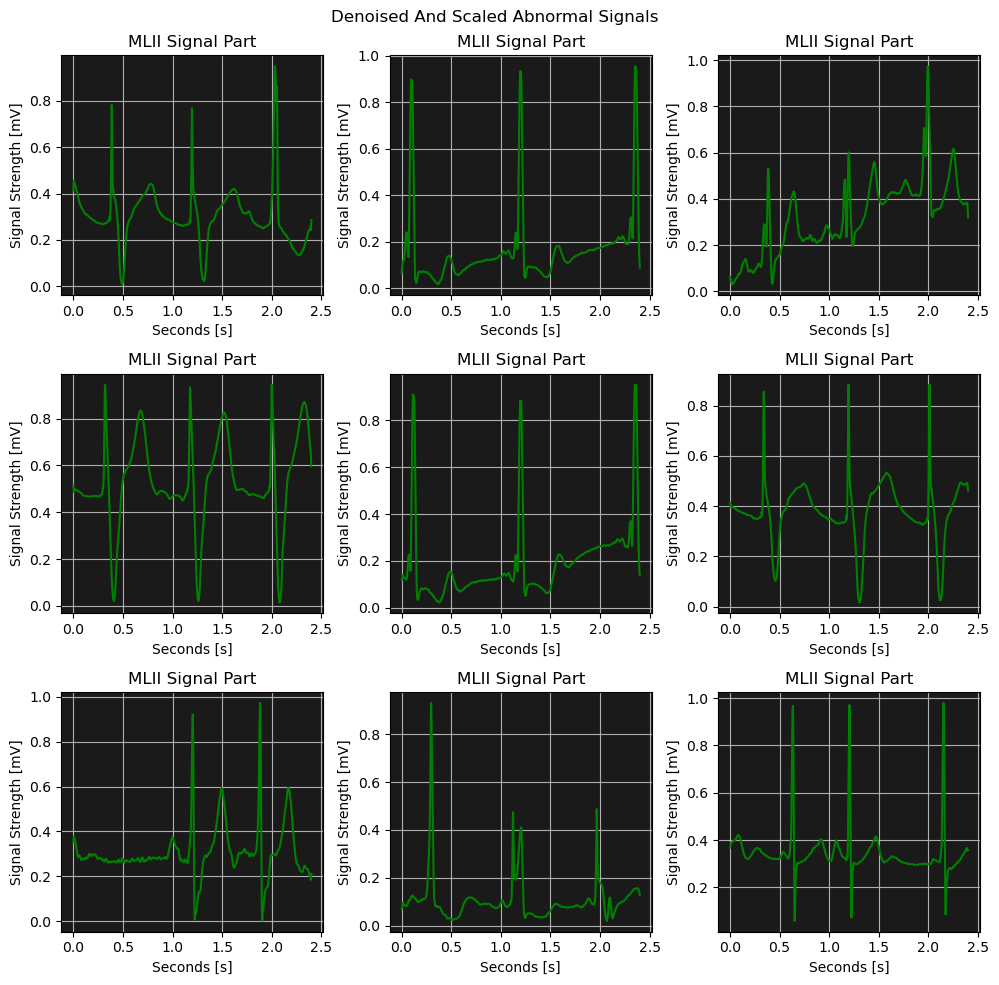

In [60]:

fig, axes = plt.subplots(figsize=(10,10), nrows=3, ncols=3)

for ax in axes.flatten():
    plot_signal_data(ax, tt, temp[np.random.randint(0, len(temp)-1)])

fig.suptitle("Denoised And Scaled Abnormal Signals")
plt.tight_layout()
plt.show()

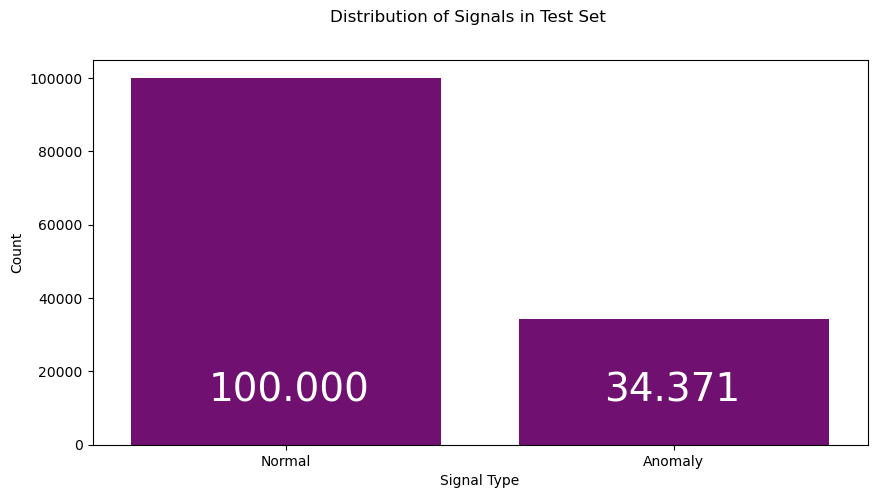

In [126]:
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(x=y_test, ax=ax, color="purple")
ax.annotate("100.000", (-0.2, 12000), color="white", fontsize=28)
ax.annotate("34.371", (0.82, 12000), color="white", fontsize=28)

ax.set_xticklabels(["Normal", "Anomaly"])
ax.set_xlabel("Signal Type")
ax.set_ylabel("Count")
fig.suptitle("Distribution of Signals in Test Set")

plt.show()

# Fully Connected AutoEncoder

In [145]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model_cp.keras", save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

input_shape = (X_train.shape[1], )  # signal length

encoder = models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),  # laten space
])

decoder = models.Sequential([
    layers.Dense(32, activation='relu', input_shape=(16,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(input_shape[0], activation='sigmoid')
])

autoencoder = models.Sequential([encoder, decoder])

autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_9 (Sequential)            │ ?                           │          57,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_10 (Sequential)           │ ?                           │          58,816 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 116,784 (456.19 KB)

 Trainable params: 116,784 (456.19 KB)

 Non-trainable params: 0 (0.00 B)

In [147]:
history = autoencoder.fit(
    X_train, 
    X_train,
    epochs=50, 
    batch_size=48, 
    validation_split=0.2,
    shuffle=True,
    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/50
8334/8334 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - loss: 0.0106 - val_loss: 0.0053
Epoch 2/50
8334/8334 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.0050 - val_loss: 0.0044
Epoch 3/50
8334/8334 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.0043 - val_loss: 0.0040
Epoch 4/50
8334/8334 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 5/50
8334/8334 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 6/50
8334/8334 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 7/50
8334/8334 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 8/50
8334/8334 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 9/50
8334/8334 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 10/50
8334/8334 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 11/50
8334/8334 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 12/50
8334/83

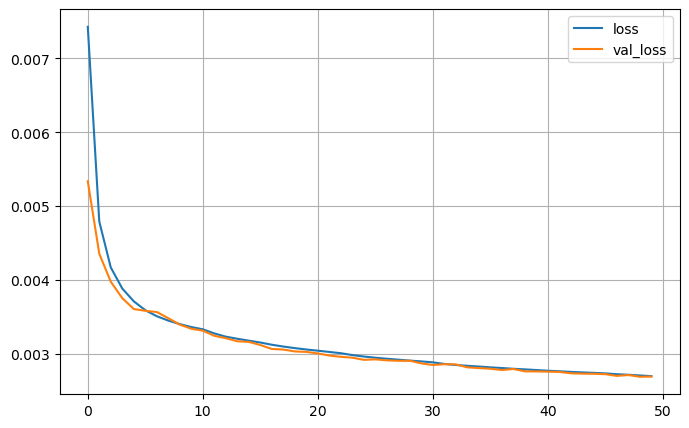

In [149]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

In [9]:
autoencoder = models.load_model("model_cp.keras")

In [45]:
test_decoded_1 = autoencoder.predict(np.array([normal[0]]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [33]:
mean_squared_error(normal[0], test_decoded_1[0])

0.0009317757720587384

In [19]:
def plot_between_signals(ax: mpl.axes.Axes, x: np.array, y1: np.array, y2: np.array, plot_kws={}):
    ax.fill_between(x, y1, y2, **plot_kws)

    return ax

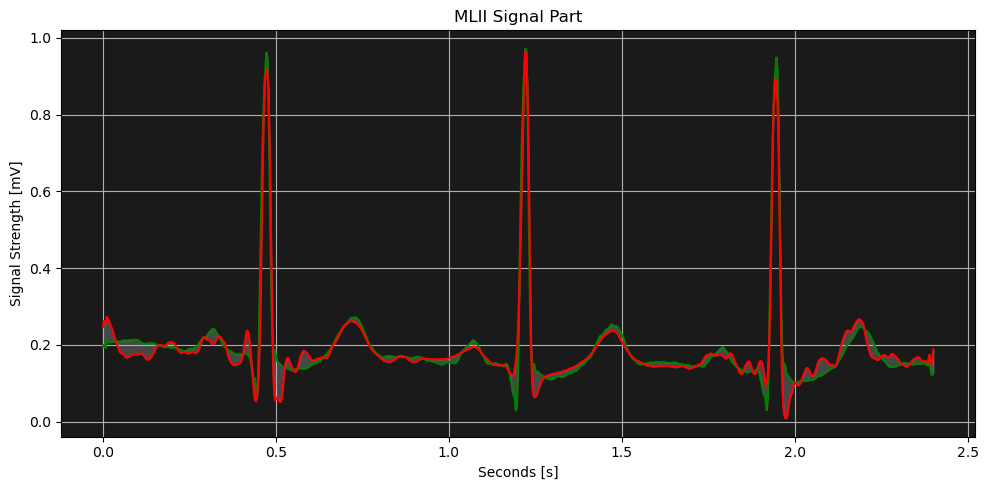

In [49]:
fig, ax = plt.subplots(figsize=(10,5))

plot_signal_data(ax, tt, normal[0])
plot_signal_data(ax, tt, test_decoded_1[0], plot_kws={"c": "red"})
plot_between_signals(ax, tt, normal[0], test_decoded_1[0], plot_kws={"color": "white", "alpha": 0.2})

plt.grid()
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


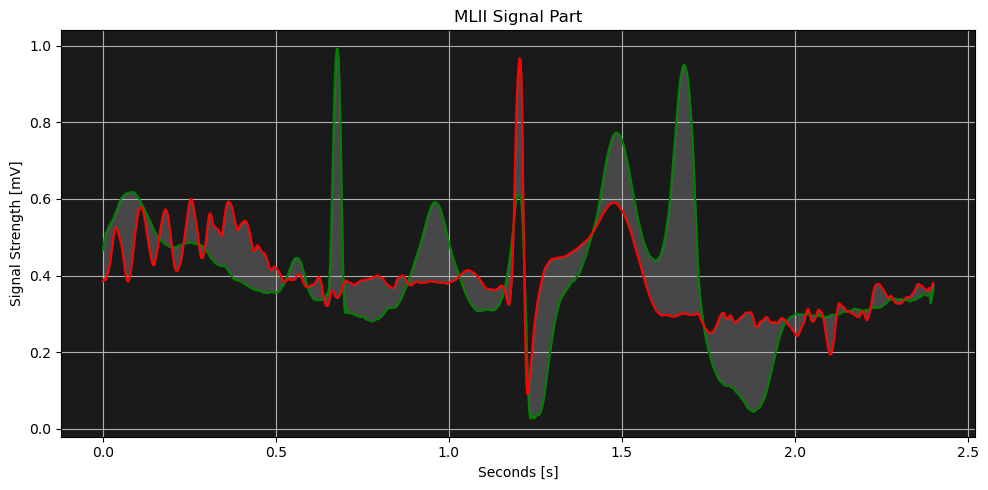

In [51]:
test_decoded_2 = autoencoder.predict(np.array([temp[50]]))

fig, ax = plt.subplots(figsize=(10,5))

plot_signal_data(ax, tt, temp[50])
plot_signal_data(ax, tt, test_decoded_2[0], plot_kws={"c": "red"})
plot_between_signals(ax, tt, temp[50], test_decoded_2[0], plot_kws={"color": "white", "alpha": 0.2})

plt.grid()
plt.tight_layout()
plt.show()

In [61]:
test_signals = autoencoder.predict(X_test)

4200/4200 ━━━━━━━━━━━━━━━━━━━━ 4s 860us/step


In [65]:
reconstruction_error = np.mean(np.square(X_test - test_signals), axis=1)  # mse for every signal sample

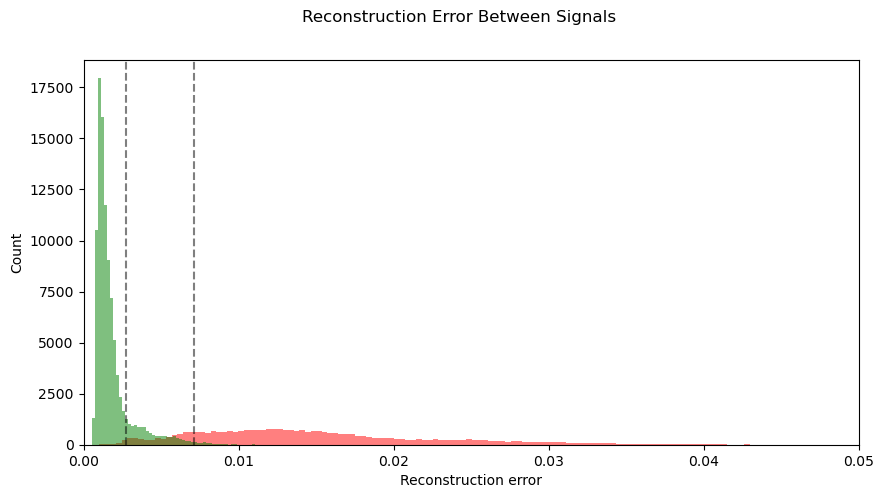

In [129]:
anomaly_q001 = np.quantile(reconstruction_error[anomaly_ids], 0.01)
normal_q099 = np.quantile(reconstruction_error[normal_ids], 0.99)

fig, ax = plt.subplots(figsize=(10,5))

ax.hist(reconstruction_error[anomaly_ids], bins=200, color="red", alpha=0.5)
ax.hist(reconstruction_error[normal_ids], bins=100, color="green", alpha=0.5)

ax.axvline(x=anomaly_q001, color="black", alpha=0.5, linestyle="--")
ax.axvline(x=normal_q099, color="black", alpha=0.5, linestyle="--")

ax.set_xlabel("Reconstruction error")
ax.set_ylabel("Count")

fig.suptitle("Reconstruction Error Between Signals")

ax.set_xlim([0, 0.05])

plt.show()